# Assignment 7
Devananth V- Ep20Btech11004

In [1]:
!pip install emcee
!pip install nestle
!pip install astroML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 KB 1.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for nestle: filename=nestle-0.2.0-py3-none-any.whl size=12455 sha256=0d2984696f3b4057f29a999cd049a7e475b9cc2c857d489a8f5ab69857abb7a5
  Stored in directory: /root/.cache/pip/wheels/70/7c/9b/1a17c0baee6f6741119e272d5dff576bb8abcd58afe4311d52
Successfully built nestle
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 KB 5.9 MB/s eta 0:00:00


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
from scipy import optimize, stats
from sklearn.neighbors import KernelDensity
import nestle

Q1

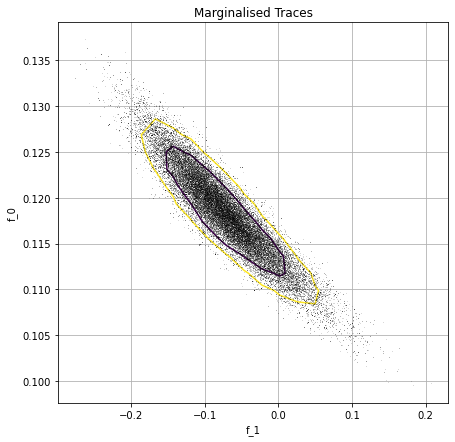

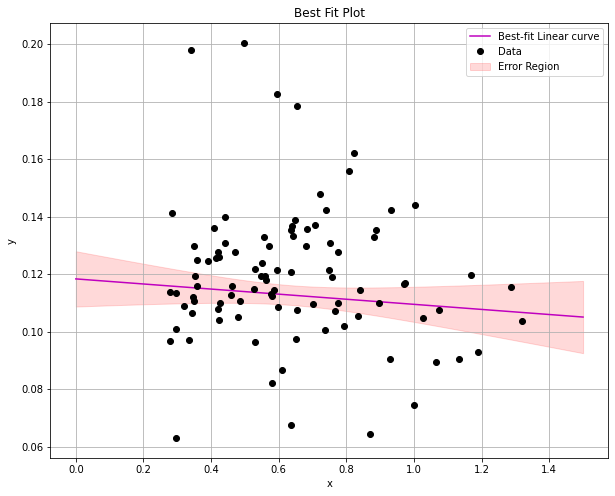

In [25]:
def log_prior(theta):
 m, b = theta
 if -0.5 < m < 0.5 and 0 < b < 0.5:
  return 0.0
 return -np.inf

def log_posterior(theta, x, y, y_err):
 log_pr = log_prior(theta)
 if not np.isfinite(log_pr):
  return -np.inf
 return log_pr + log_likelihood(theta, x, y, y_err)

def log_likelihood(theta, x, y, y_err): 
  m, b = theta
  y_model = b*(1+m*x)
  sig = y_err**2 
  return -0.5*np.sum((y-y_model)**2 / sig + np.log(sig))

def sigma_level(t1, t2, nbins=20):
 L, xbins, ybins = np.histogram2d(t1, t2, nbins)
 L[L == 0] = 1E-16
 shape = L.shape
 L = L.ravel()
 i_sort = np.argsort(L)[::-1]
 i_unsort = np.argsort(i_sort)
 L_cumsum = L[i_sort].cumsum()
 L_cumsum /= L_cumsum[-1]
 sigma = L_cumsum[i_unsort].reshape(shape)
 xbins = 0.5 * (xbins[1:] + xbins[:-1])
 ybins = 0.5 * (ybins[1:] + ybins[:-1])
 return xbins, ybins, sigma

data = np.loadtxt('https://iith.ac.in/~shantanud/fgas_spt.txt')
z = data[:, 0]
fgas = data[:, 1]
fgas_error = data[:, 2]

nwalkers = 50
nsamples = 1000 
nburn = 1000
nsteps = nburn + nsamples
guesses = np.array([np.random.uniform(-0.5, 0.5, nwalkers), np.random.uniform(0.0, 0.5,nwalkers)]).T
ndims = guesses.shape[1]
sampler = emcee.EnsembleSampler(nwalkers, ndims, log_posterior, args=[z,fgas,fgas_error])
sampler.run_mcmc(guesses, nsteps)
samples = sampler.chain[:, nburn:, :].reshape((-1, ndims))
 
trace = samples.T
xbins, ybins, sigma = sigma_level(trace[0],trace[1])
plt.figure(figsize=(7,7))
plt.contour(xbins, ybins, sigma.T, levels=[0.68,0.90])
plt.plot(trace[0], trace[1], ',k', alpha=0.15)
plt.title("Marginalised Traces")
plt.xlabel('f_1')
plt.ylabel('f_0')
plt.grid()
plt.show()

x1 = np.linspace(0, 1.5, 2000)
m, b = trace[:2]
y1 = b[:,None]*(1+m[:,None]*x1)
bound1 = y1.mean(0)-2*y1.std(0)
bound2 = y1.mean(0)+2*y1.std(0)
plt.figure(figsize=(10,8))
plt.plot(x1, y1.mean(0),'-m', label='Best-fit Linear curve')
plt.plot(z, fgas, 'ok', label='Data')
plt.fill_between(x1, bound1, bound2, alpha=0.15, color = 'r', label='Error Region')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Best Fit Plot")
plt.grid()
plt.legend()
plt.show()

Q2

In [22]:
data = np.array([[0.42, 0.72, 0., 0.3, 0.15,0.09, 0.19, 0.35, 0.4, 0.54,
 0.42, 0.69, 0.2, 0.88, 0.03,0.67, 0.42, 0.56, 0.14, 0.2],
 [0.33, 0.41, -0.22, 0.01, -0.05, -0.05, -0.12, 0.26, 0.29, 0.39,
 0.31, 0.42, -0.01, 0.58, -0.2, 0.52, 0.15, 0.32, -0.13, -0.09],
 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]])

def polynomial_fit(theta, x):
 return sum(t * x ** n for (n, t) in enumerate(theta))

def log_likelihood(theta, data=data):
 x, y, sig_y = data
 y_model = polynomial_fit(theta, x)
 return -0.5 * np.sum(np.log(2 * np.pi * sig_y ** 2) + (y - y_model) ** 2 / sig_y **2)

def prior(theta):
 return 200*theta - 100
 
result_linear = nestle.sample(log_likelihood, prior, 2)
print("Linear model")
print(result_linear.summary())
result_quad = nestle.sample(log_likelihood, prior, 3)
print("Quadratic model")
print(result_quad.summary())
print()
z1=np.exp(result_linear.logz)
z2=np.exp(result_quad.logz)
print("Bayes factor (quad/linear):",z2/z1)

Linear model
niter: 1598
ncall: 2970
nsamples: 1698
logz:  6.896 +/-  0.375
h: 14.071
Quadratic model
niter: 2118
ncall: 3878
nsamples: 2218
logz:  2.542 +/-  0.435
h: 18.929

Bayes factor (quad/linear): 0.012853120868632925


Q3

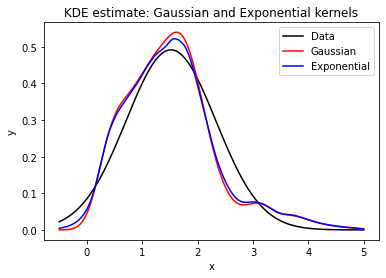

In [26]:
df= pd.read_csv('data.txt',sep = '\s+')
data = df['z']
data = data.to_numpy()

x1 = np.linspace(-0.5, 5, 1000)
dist = stats.norm(np.mean(data),np.std(data))
pdf = dist.pdf(x1)

pdf_gaus = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(data[:,np.newaxis]).score_samples(x1[:,np.newaxis])
pdf_gau = np.exp(pdf_gaus)

pdf_exp = KernelDensity(kernel='exponential', bandwidth=0.2).fit(data[:,np.newaxis]).score_samples(x1[:,np.newaxis])
pdf_ex = np.exp(pdf_exp)

plt.plot(x1 , pdf, 'k', label = 'Data')
plt.plot(x1, pdf_gau, 'r', label = 'Gaussian')
plt.plot(x1, pdf_ex, 'b', label = 'Exponential')
plt.title('KDE estimate: Gaussian and Exponential kernels')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()